# Table of Contents
 <p><div class="lev1"><a href="#Optimize-Dynamic-Subgraphs"><span class="toc-item-num">1&nbsp;&nbsp;</span>Optimize Dynamic Subgraphs</a></div><div class="lev2"><a href="#Initialize-Environment"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev2"><a href="#Generate-List-of-Data"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate List of Data</a></div><div class="lev2"><a href="#Construct-Configuration-Matrices"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Construct Configuration Matrices</a></div><div class="lev2"><a href="#Parameter-Search-Space"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Parameter Search Space</a></div><div class="lev2"><a href="#Run-Non-Negative-Matrix-Factorization-Algorithm"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Run Non-Negative Matrix Factorization Algorithm</a></div><div class="lev2"><a href="#Analyze-Parameter-Search-Space"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Analyze Parameter Search Space</a></div><div class="lev1"><a href="#Detect-Dynamic-Subgraphs"><span class="toc-item-num">2&nbsp;&nbsp;</span>Detect Dynamic Subgraphs</a></div><div class="lev2"><a href="#Initialize-Environment"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev2"><a href="#Run-Non-Negative-Matrix-Factorization-Algorithm"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Run Non-Negative Matrix Factorization Algorithm</a></div><div class="lev2"><a href="#Consensus-NMF"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Consensus NMF</a></div><div class="lev2"><a href="#Consensus-Subgraphs"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Consensus Subgraphs</a></div><div class="lev2"><a href="#Subgraphs-of-Brain-Systems"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Subgraphs of Brain Systems</a></div><div class="lev3"><a href="#Formulate-ROI-Dict"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Formulate ROI Dict</a></div><div class="lev3"><a href="#Convert-ROI-Subgraphs-to-Brain-System-Subgraphs"><span class="toc-item-num">2.5.2&nbsp;&nbsp;</span>Convert ROI Subgraphs to Brain System Subgraphs</a></div><div class="lev3"><a href="#Plot-all-Brain-System-Subgraphs"><span class="toc-item-num">2.5.3&nbsp;&nbsp;</span>Plot all Brain System Subgraphs</a></div>

# Optimize Dynamic Subgraphs

## Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
os.chdir('./Analysis_Notebooks/')

path_CoreData = '/home/akhambhati/JagHome/hoth_research/CORE.fMRI_cogcontrol.medaglia'
path_PeriphData = '/home/akhambhati/JagHome/hoth_research/RSRCH.NMF_CogControl'
path_InpData = path_PeriphData + '/e01-FuncNetw'
path_ExpData = path_PeriphData + '/e02b-FuncSubg'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/home/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Generate List of Data

In [2]:
inp_fname = glob.glob('{}/*.npz'.format(path_InpData))

expr_dict = {}
for fname in inp_fname:
    subj_id = fname.split('/')[-1].split('.')[0]
    expr_id = fname.split('/')[-1].split('.')[1]
    
    try:
        expr_dict[expr_id]['adj_files'].append(fname)
    except:
        expr_dict[expr_id] = {}
        expr_dict[expr_id]['adj_files'] = []
        expr_dict[expr_id]['adj_files'].append(fname)

## Construct Configuration Matrices

In [13]:
key_ord = ['adj_rs_pos', 'adj_rs_neg',
           'adj_lo_pos', 'adj_lo_neg',
           'adj_hi_pos', 'adj_hi_neg']

cfg_list = []
cfg_key = []
for expr_id in expr_dict.keys():    
    for fname in expr_dict[expr_id]['adj_files']:
        df = np.load(fname)
        
        for key in key_ord:
            cfg_matr = conv_adj_matr_to_cfg_matr(df[key])
            for cfg_vec in cfg_matr:
                cfg_list.append(cfg_vec)
                cfg_key.append('{}_{}'.format(key, expr_id))
        
np.savez('{}/NMF_Optimization.CfgMatr.npz'.format(path_ExpData),
         cfg_matr=np.array(cfg_list),
         cfg_key=np.array(cfg_key))

## Parameter Search Space

In [14]:
# Set search ranges
alpha = 0.0
beta = 0.0
rank = [2, 61]
n_search = 10

# Generate parameter set
param_set = []
ii = 0
for i in xrange(n_search):
    for rr in np.arange(rank[0], rank[1]):    
        param_set.append({'id': ii+1,
                          'alpha': alpha,
                          'beta': beta,
                          'rank': rr})
        ii += 1

np.savez('{}/NMF_Optimization.Params.npz'.format(path_ExpData), param_set=param_set)

## Run Non-Negative Matrix Factorization Algorithm
*__WARNING: Will Delete Existing Output__*

In [15]:
# Remove all existing output (retains pipe/pipeline definitions)
rm_outp = glob.glob("{}/NMF_Optimization.Param_*".format(path_ExpData))

for rm_type in [rm_outp]:
    for path in rm_type:
        try:
            os.remove(path)
        except:
            print("{} not found".format(path))

In [4]:
param_set = np.load('{}/NMF_Optimization.Params.npz'.format(path_ExpData))['param_set']
path_cfg_matr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_ExpData))[0]

proc_item = []
for param in param_set:
    res_path = '{}/NMF_Optimization.Param_{}.npz'.format(path_ExpData, param['id'])
    if os.path.exists(res_path):
        continue
    else:
        proc_item.append({'path_cfg_matr': path_cfg_matr,
                          'param': param})
print('There are {} jobs to process.'.format(len(proc_item)))
    
# Submit proc_item list as jobs to qsub
job_file = open('./e02-job-NMF_Optimization', 'w')
job_file.write('#!/bin/bash\n\n')
for pitem in proc_item:    
    stdout_path = '{}/NMF_Optimization.Param_{}.stdout'.format(path_ExpData, pitem['param']['id'])
    stderr_path = '{}/NMF_Optimization.Param_{}.stderr'.format(path_ExpData, pitem['param']['id'])
    
    py_str = './pywrap-nmf_optimization {} {} {} {} {} {}'.format(
        pitem['path_cfg_matr'], pitem['param']['id'], 
        pitem['param']['alpha'], pitem['param']['beta'],
        pitem['param']['rank'], path_ExpData)

    cmd_str = 'qsub -cwd -o {} -e {} -l h_vmem=6.1G,s_vmem=6G'.format(stdout_path, stderr_path)

    job_file.write('{} {}\n'.format(cmd_str, py_str))
job_file.close()    

There are 0 jobs to process.


## Analyze Parameter Search Space

/home/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


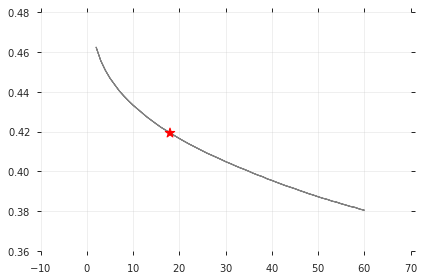

In [21]:
%matplotlib inline

res_opt_path = glob.glob('{}/NMF_Optimization.Param_*.npz'.format(path_ExpData))

recons_error = []
for path in res_opt_path:
    res_opt = np.load(path)
    
    fac_subnet = res_opt['fac_subnet']
    fac_coef = res_opt['fac_coef']
    err = res_opt['err'][-1]
    
    n_fac = fac_subnet.shape[0]
    n_conn = fac_subnet.shape[1]
    n_obs = fac_coef.shape[1]
    
    recons_error.append([n_fac, err])
recons_error = np.array(recons_error)
    
n_fac_list = np.unique(recons_error[:, 0])
recons_error_mean = np.zeros(len(n_fac_list))
recons_error_std = np.zeros(len(n_fac_list))
for fac_ii, fac_id in enumerate(n_fac_list):
    fac_ix = np.flatnonzero(recons_error[:, 0] == fac_id)
    recons_error_mean[fac_ii] = recons_error[fac_ix, 1].mean()
    recons_error_std[fac_ii] = recons_error[fac_ix, 1].std() / np.sqrt(len(fac_ix))

plt.figure()
ax = plt.subplot(111)
ax.fill_between(n_fac_list, recons_error_mean, recons_error_mean+recons_error_std)
ax.fill_between(n_fac_list, recons_error_mean, recons_error_mean-recons_error_std)    
opt_ix = Codebase.Utilities.optimization.find_elbow(recons_error_mean)
ax.scatter(n_fac_list[opt_ix], recons_error_mean[opt_ix], color='r', marker='*', s=100.0)
plt.show()    

np.savez('{}/NMF_Optimization.Num_Subgraph.npz'.format(path_ExpData),
         n_subgraph=n_fac_list[opt_ix])

# Detect Dynamic Subgraphs

## Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
os.environ['MKL_NUM_THREADS'] = '1'
import sys
import glob
import json
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
os.chdir('./Analysis_Notebooks/')

path_CoreData = '/home/akhambhati/JagHome/hoth_research/CORE.fMRI_cogcontrol.medaglia'
path_PeriphData = '/home/akhambhati/JagHome/hoth_research/RSRCH.NMF_CogControl'
path_InpData = path_PeriphData + '/e01-FuncNetw'
path_ExpData = path_PeriphData + '/e02b-FuncSubg'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/home/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Run Non-Negative Matrix Factorization Algorithm
*__WARNING: Will Delete Existing Output__*

In [16]:
# Remove all existing output (retains pipe/pipeline definitions)
rm_outp = glob.glob("{}/NMF_Optimized.Seed_*".format(path_ExpData))

for rm_type in [rm_outp]:
    for path in rm_type:
        try:
            os.remove(path)
        except:
            print("{} not found".format(path))

In [9]:
# Optimal Parameter Set
opt_alpha = 0.0
opt_beta = 0.0
opt_rank = int(np.load('{}/NMF_Optimization.Num_Subgraph.npz'.format(path_ExpData))['n_subgraph'])
n_seed = 1000

param_set = []
for seed in xrange(n_seed):
    param_set.append({'id': seed+1,
                      'alpha': opt_alpha,
                      'beta': opt_beta,
                      'rank': opt_rank})
    

path_cfg_matr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_ExpData))[0]

proc_item = []
for param in param_set:
    res_path = '{}/NMF_Optimized.Seed_{}.npz'.format(path_ExpData, param['id'])
    if os.path.exists(res_path):
        continue
    else:
        proc_item.append({'path_cfg_matr': path_cfg_matr,
                          'param': param})
print('There are {} jobs to process.'.format(len(proc_item)))

# Submit proc_item list as jobs to qsub
job_file = open('./e02-job-NMF_Optimized', 'w')
job_file.write('#!/bin/bash\n\n')
for pitem in proc_item:    
    stdout_path = '{}/NMF_Optimized.Seed_{}.stdout'.format(path_ExpData, pitem['param']['id'])
    stderr_path = '{}/NMF_Optimized.Seed_{}.stderr'.format(path_ExpData, pitem['param']['id'])
    
    py_str = './pywrap-nmf_optimized {} {} {} {} {} {}'.format(
        pitem['path_cfg_matr'],
        pitem['param']['id'], pitem['param']['alpha'], pitem['param']['beta'],
        pitem['param']['rank'], path_ExpData)

    cmd_str = 'qsub -cwd -o {} -e {} -l h_vmem=6.1G,s_vmem=6G'.format(stdout_path, stderr_path)
    
    job_file.write('{} {}\n'.format(cmd_str, py_str))
job_file.close()    

There are 204 jobs to process.


## Consensus NMF

In [ ]:
from Codebase.Networks.SubgraphDetection.nonnegfac import nmf

path_cfg_matr = glob.glob('{}/NMF_Optimization.CfgMatr.npz'.format(path_ExpData))
seed_path = glob.glob('{}/NMF_Optimized.Seed_*.npz'.format(path_ExpData))
n_seed_block = 100
seed_path_blocks = np.random.permutation(seed_path).reshape(-1, n_seed_block)

for block_ix, seed_path_block in enumerate(seed_path_blocks):
    print('Processing Block: {}'.format(block_ix+1))

    # Concatenate subgraphs from block seeds
    fac_subnet_seeds = []
    for path_block in seed_path_block:
        data = np.load(path_block, mmap_mode='r')
        fac_subnet = data['fac_subnet'][:, :]
        data.close()

        n_fac = fac_subnet.shape[0]
        n_conn = fac_subnet.shape[1]

        for fac_ix in xrange(n_fac):
            fac_subnet_seeds.append(fac_subnet[fac_ix, :])
    fac_subnet_seeds = np.array(fac_subnet_seeds)

    n_obs = fac_subnet_seeds.shape[0]
    n_conn = fac_subnet_seeds.shape[1]
    
    if block_ix == 0:
        fac_subnet_init = np.random.uniform(low=0.0, high=1.0, size=(n_fac, n_conn))
    else:
        fac_subnet_init = fac_cons_subnet
    fac_coef_init = np.random.uniform(low=0.0, high=1.0, size=(n_fac, n_obs))

    # Consensus Subgraphs
    fac_cons_subnet, fac_cons_seeds, err = nmf.snmf_bcd(
        fac_subnet_seeds,
        alpha=0.0,
        beta=0.0,
        fac_subnet_init=fac_subnet_init,
        fac_coef_init=fac_coef_init,
        max_iter=100, verbose=True)

# Consensus Coefficients
data_cfg = np.load(path_cfg_matr, mmap_mode='r')[0]
cfg_matr = np.nan_to_num(data_cfg['cfg_matr'][:, :])
n_win = cfg_matr.shape[0]
fac_cons_subnet_2, fac_cons_coef_2, err = nmf.snmf_bcd(
    cfg_matr,
    alpha=0.0,
    beta=0.0,
    fac_subnet_init=fac_cons_subnet,
    fac_coef_init=np.random.uniform(low=0.0, high=1.0, size=(n_fac, n_win)),
    max_iter=100, verbose=True)

# Cache the Consensus NMF result
np.savez("{}/NMF_Consensus.npz".format(path_ExpData),
         fac_subnet=fac_cons_subnet_2, fac_coef=fac_cons_coef_2, err=err)

Processing Block: 1

Beginning Non-Negative Matrix Factorization


## Consensus Subgraphs

Plotting All Subgraphs...


/home/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


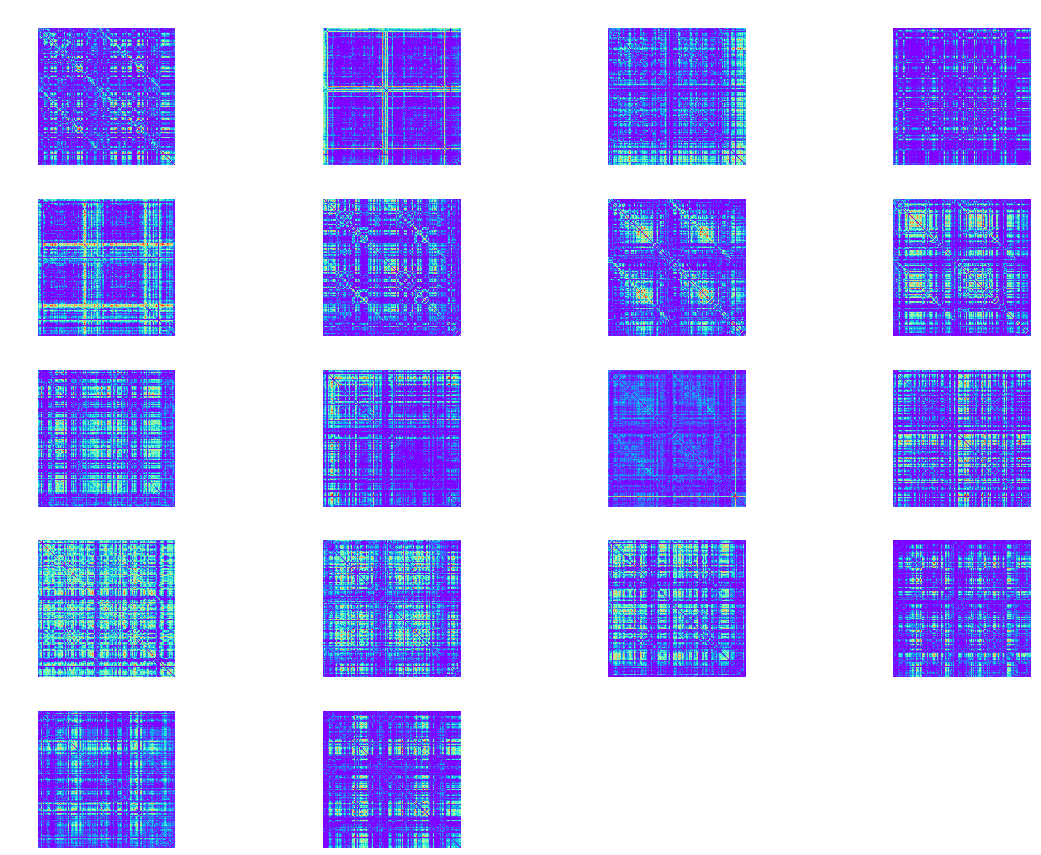

In [18]:
print('Plotting All Subgraphs...')
df = np.load('{}/NMF_Consensus.npz'.format(path_ExpData))
rank = df['fac_subnet'].shape[0]
n_col = int(np.sqrt(rank))
n_row = int(np.ceil(rank / n_col))

%matplotlib inline
plt.figure(figsize=(16, 12))
for ii in xrange(rank):
    ax = plt.subplot(n_row, n_col, ii+1)
    ax.matshow(conv_cfg_vec_to_adj_matr(df['fac_subnet'][ii, :]), cmap='rainbow')
    ax.set_axis_off()
plt.show()

## Subgraphs of Brain Systems

### Formulate ROI Dict

In [19]:
df_parcel = pd.read_csv('{}/LausanneScale125.csv'.format(path_CoreData))

all_roi_names = []

roi_dict = {}
for lbl_id, lbl_roi, lbl_hemi in zip(df_parcel.Label_ID, df_parcel.ROI, df_parcel.Hemisphere):
    roi_name = '{}_{}'.format(lbl_hemi, lbl_roi.split('_')[0])
    #roi_name = lbl_roi.split('_')[0]
    
    if roi_name not in all_roi_names:
        all_roi_names.append(roi_name)

    try:
        roi_dict[roi_name]
    except KeyError:
        roi_dict[roi_name] = []

    roi_dict[roi_name].append(lbl_id-1)

### Convert ROI Subgraphs to Brain System Subgraphs

In [20]:
bs_fac_subnet = np.zeros((rank, len(all_roi_names), len(all_roi_names)))

for fac_i, subg in enumerate(df['fac_subnet']):
    adj = conv_cfg_vec_to_adj_matr(subg)
    
    for ij_ii, ij_roi in enumerate(all_roi_names):
        for ik_ii, ik_roi in enumerate(all_roi_names):
            
            mean_conn = adj[roi_dict[ij_roi], :][:, roi_dict[ik_roi]].mean()
            bs_fac_subnet[fac_i, ij_ii, ik_ii] = mean_conn

### Plot all Brain System Subgraphs

Plotting All Subgraphs...


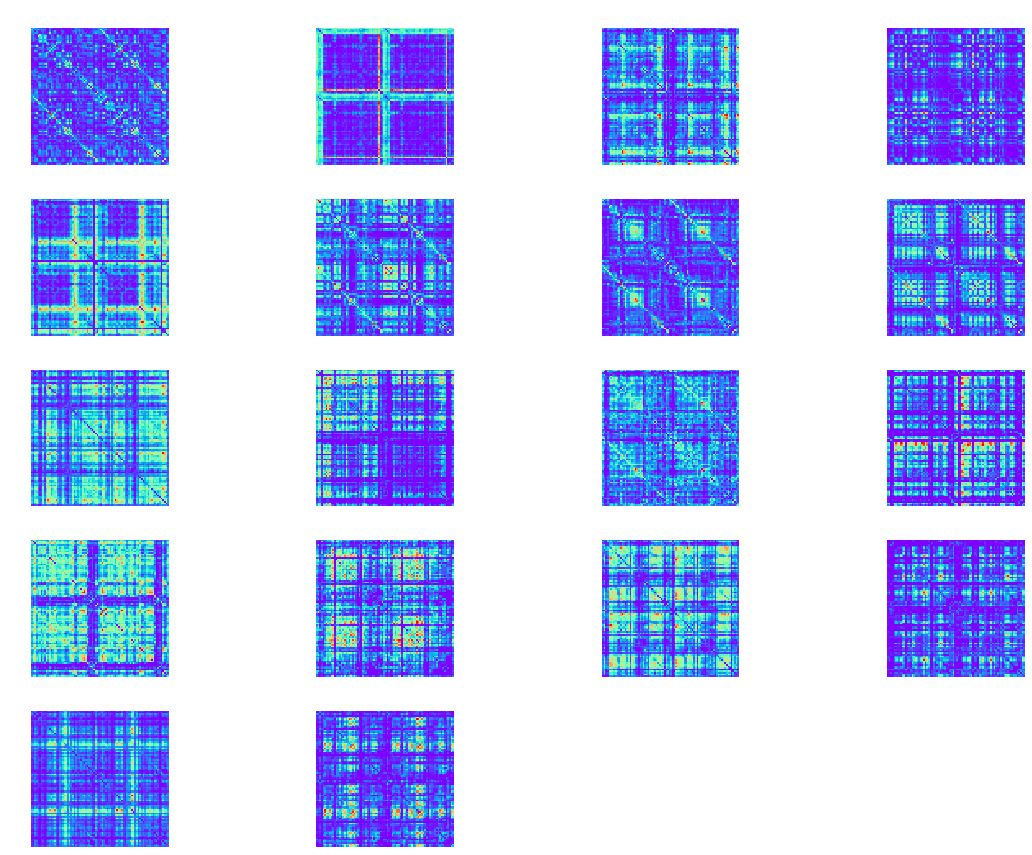

In [21]:
print('Plotting All Subgraphs...')
rank = bs_fac_subnet.shape[0]
n_col = int(np.sqrt(rank))
n_row = int(np.ceil(rank / n_col))

%matplotlib inline
plt.figure(figsize=(16, 12))
for ii in xrange(rank):
    ax = plt.subplot(n_row, n_col, ii+1)
    ax.matshow(bs_fac_subnet[ii, :, :], cmap='rainbow')
    ax.set_axis_off()
plt.show()

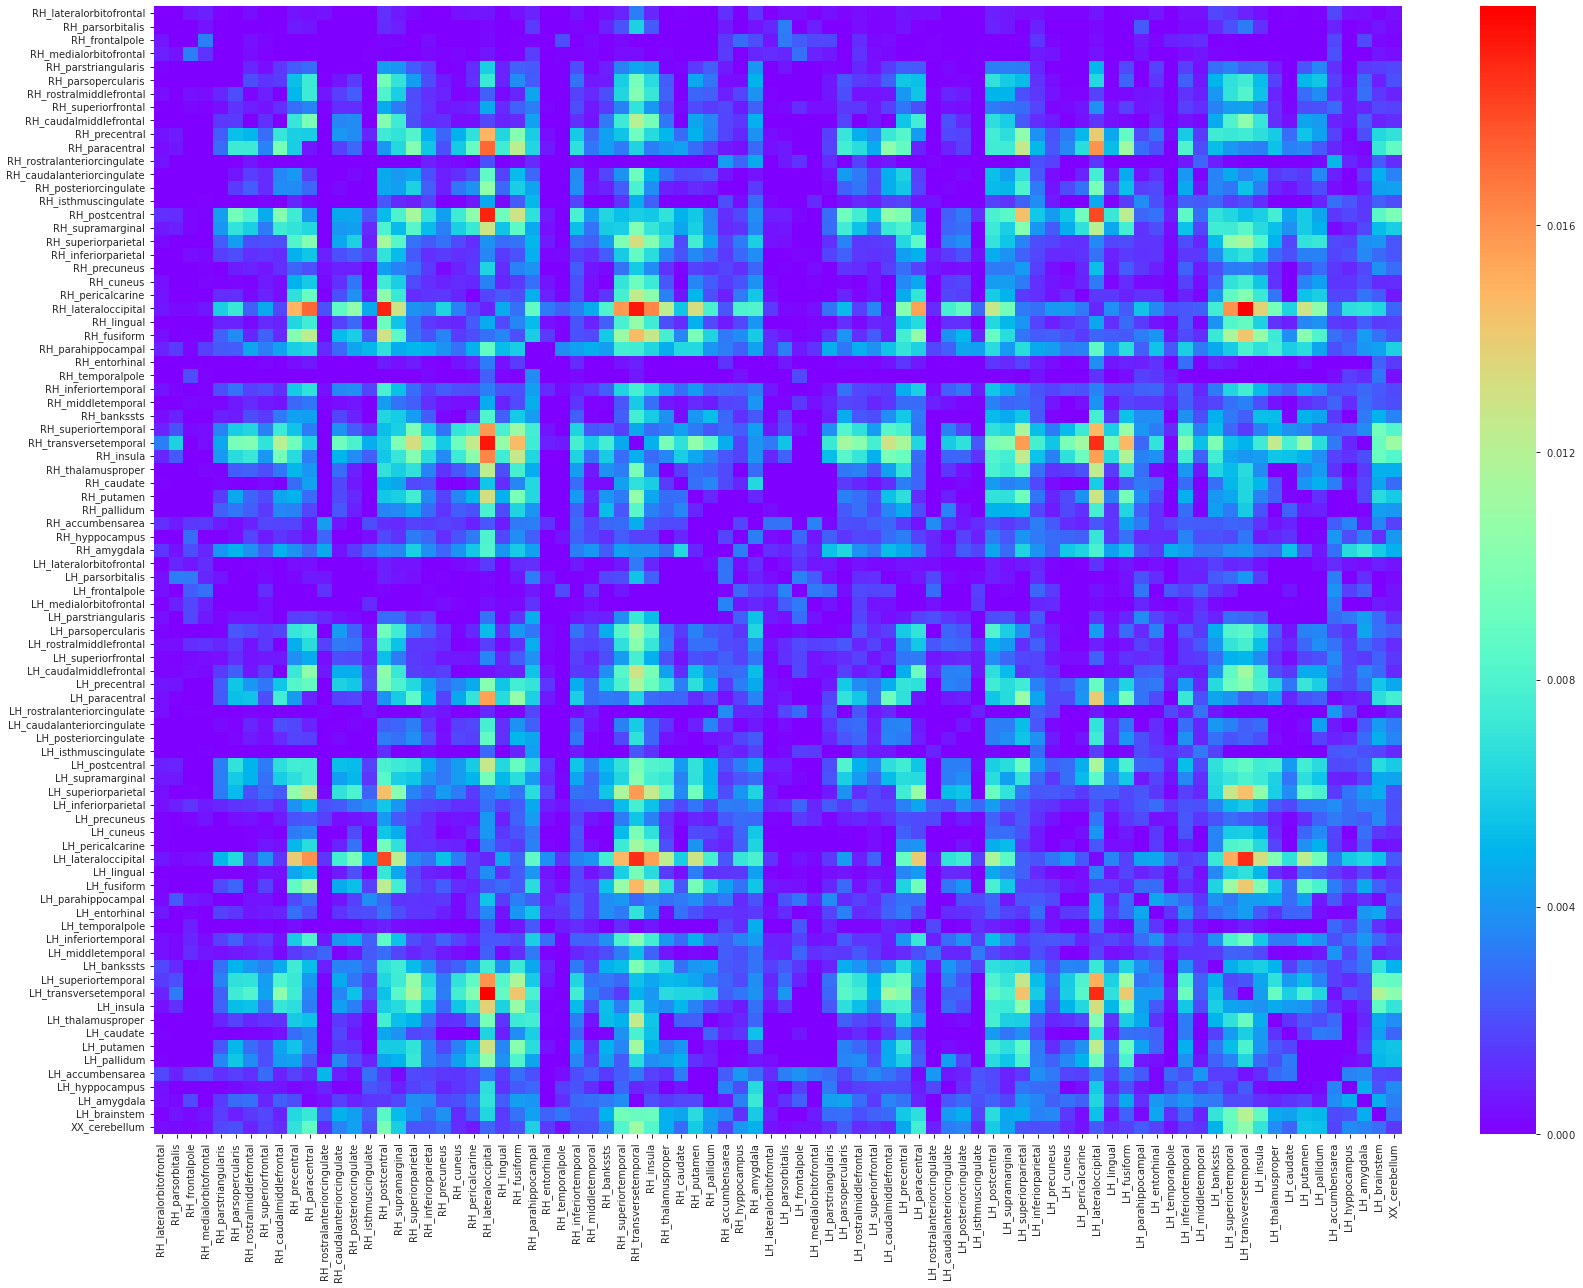

In [22]:
plt.figure(figsize=(24,18))
sns.heatmap(bs_fac_subnet[15,:,:], cmap='rainbow', xticklabels=all_roi_names, yticklabels=all_roi_names)

In [23]:
np.array(all_roi_names)[np.argsort(np.sum(bs_fac_subnet[15,:,:], axis=0))[::-1]]

array(['RH_transversetemporal', 'RH_lateraloccipital',
       'LH_lateraloccipital', 'RH_postcentral', 'LH_transversetemporal',
       'RH_insula', 'LH_superiortemporal', 'LH_postcentral',
       'RH_supramarginal', 'RH_superiortemporal', 'LH_precentral',
       'LH_superiorparietal', 'RH_precentral', 'RH_parahippocampal',
       'RH_fusiform', 'RH_paracentral', 'LH_insula', 'LH_supramarginal',
       'LH_bankssts', 'LH_fusiform', 'RH_superiorparietal', 'LH_brainstem',
       'LH_paracentral', 'RH_amygdala', 'LH_putamen', 'XX_cerebellum',
       'RH_putamen', 'LH_inferiortemporal', 'LH_pallidum',
       'RH_thalamusproper', 'LH_caudalmiddlefrontal', 'LH_parsopercularis',
       'RH_inferiortemporal', 'LH_thalamusproper', 'LH_inferiorparietal',
       'RH_bankssts', 'RH_pericalcarine', 'RH_lingual',
       'RH_inferiorparietal', 'RH_caudalmiddlefrontal',
       'RH_parsopercularis', 'LH_rostralmiddlefrontal', 'LH_amygdala',
       'RH_posteriorcingulate', 'RH_pallidum',
       'RH_cauda